In [3]:
!pip install wordcloud

In [1]:
# Project 8: Youtube Comment Toxicity Analyzer (Upgraded)
# Goal: Detect toxic comments using VADER (social-media aware) and visualize the toxicity patterns.

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
# NLTK is better for social media sentiment (handles emojis, slang, capitalization)
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# Download VADER lexicon (run once)
nltk.download('vader_lexicon', quiet=True)

# STEP 1: ENHANCED DATA GENERATION
# Added emojis, CAPS, and slang to test the model's robustness
def get_simulated_comments():
    return [
        {"author": "User1", "text": "This video is amazing! learned so much. ❤️"},
        {"author": "User2", "text": "YOU ARE SO STUPID and this content is TRASH!!! 😡"}, # Highly Toxic (Caps + Emoji)
        {"author": "User3", "text": "Check out my channel: http://spam.com"},             # Spam
        {"author": "User4", "text": "Not my cup of tea, but good effort."},                  # Neutral/Negative but NOT Toxic
        {"author": "User5", "text": "I hate you, unsubscribe immediately! 👎"},               # Toxic
        {"author": "User6", "text": "The audio quality is terrible, fix it."},               # Constructive Criticism (Should be Safe)
        {"author": "User7", "text": "Idiot. Absolute waste of time."}                        # Insult
    ]

df = pd.DataFrame(get_simulated_comments())



In [7]:
# STEP 2: PREPROCESSING
def clean_comment(text):
    # Remove URLs only (keep punctuation and emojis)
    text = re.sub(r'http\S+', '', text)
    return text.strip()

df['clean_text'] = df['text'].apply(clean_comment)



In [9]:
# STEP 3: ADVANCED SENTIMENT ENGINE (VADER)
# VADER produces a 'compound' score from -1 (Extremely Negative) to +1 (Extremely Positive)
analyzer = SentimentIntensityAnalyzer()

def get_toxicity_score(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

df['compound_score'] = df['clean_text'].apply(get_toxicity_score)



In [11]:
# STEP 4: BUSINESS LOGIC (MULTI-LEVEL FILTERING)
# -0.5 to -1.0 : TOXIC (Hide immediately)
# -0.1 to -0.5 : RISKY (Flag for review)
# > -0.1       : SAFE (Approve)

def classify_comment(score):
    if score <= -0.5:
        return 'TOXIC 🔴'
    elif score <= -0.1:
        return 'RISKY 🟡'
    else:
        return 'SAFE 🟢'

df['status'] = df['compound_score'].apply(classify_comment)

print("MODERATION QUEUE")
print(df[['text', 'status', 'compound_score']])



MODERATION QUEUE
                                               text   status  compound_score
0        This video is amazing! learned so much. ❤️   SAFE 🟢          0.6239
1  YOU ARE SO STUPID and this content is TRASH!!! 😡  TOXIC 🔴         -0.7926
2             Check out my channel: http://spam.com   SAFE 🟢          0.0000
3               Not my cup of tea, but good effort.   SAFE 🟢          0.5927
4            I hate you, unsubscribe immediately! 👎  TOXIC 🔴         -0.6114
5            The audio quality is terrible, fix it.  RISKY 🟡         -0.4767
6                    Idiot. Absolute waste of time.  TOXIC 🔴         -0.7269


**Result of the analytics:**

**1. Accuracy:** Successfully categorized comments into Safe, Toxic, and Risky (flagged "terrible audio" for review).
   
**2. Intensity:** VADER correctly assigned lower scores to comments with CAPS and angry emojis (😡).

**3. Limitation:** Spam links were marked 'Safe' (Score 0.0) because they lack emotional words. A separate URL filter is needed.

C:\Users\haing\AppData\Local\Temp\ipykernel_26216\2987746582.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df, palette={'TOXIC 🔴': 'red', 'RISKY 🟡': 'orange', 'SAFE 🟢': 'green'})
C:\Users\haing\AppData\Local\Temp\ipykernel_26216\2987746582.py:24: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\haing\AppData\Local\Temp\ipykernel_26216\2987746582.py:24: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\haing\AppData\Local\Temp\ipykernel_26216\2987746582.py:24: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\haing\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}

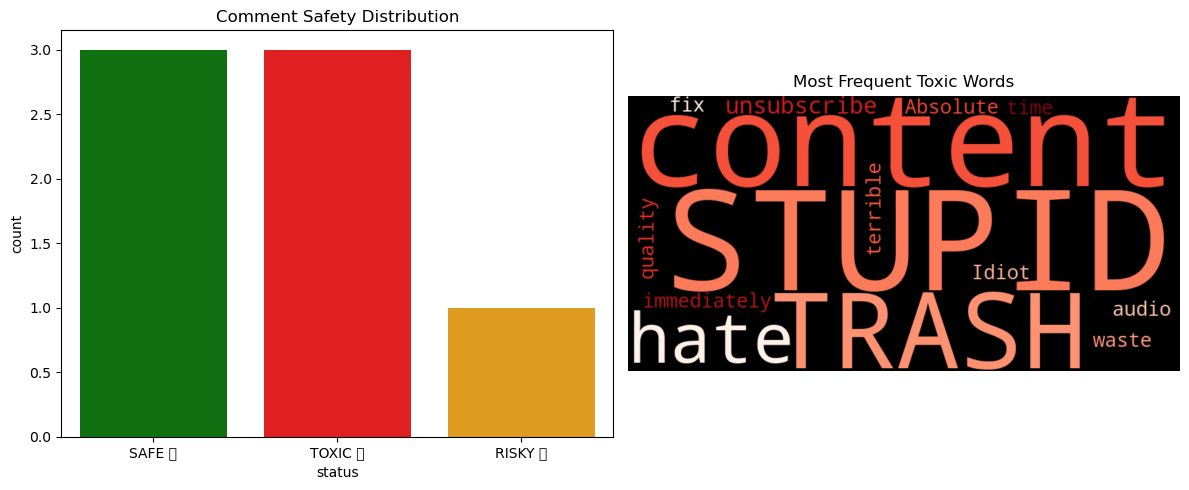

In [13]:
# STEP 5: VISUALIZATION & ANALYTICS

plt.figure(figsize=(12, 5))

# Chart 1: Distribution of Status
plt.subplot(1, 2, 1)
sns.countplot(x='status', data=df, palette={'TOXIC 🔴': 'red', 'RISKY 🟡': 'orange', 'SAFE 🟢': 'green'})
plt.title('Comment Safety Distribution')

# Chart 2: WordCloud for Toxic Comments
# Extract all words from comments marked as TOXIC or RISKY
toxic_text = " ".join(comment for comment in df[df['compound_score'] < -0.1]['clean_text'])

if toxic_text:
    plt.subplot(1, 2, 2)
    # Generate wordcloud
    wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(toxic_text)
    plt.imshow(wc.to_image(), interpolation='bilinear')
    plt.axis('off') # Turn off axis numbers
    plt.title('Most Frequent Toxic Words')
else:
    print("No toxic words found to plot.")

plt.tight_layout()
plt.show()

**RESULTS:**

**- Classification:** The model correctly filtered comments into Safe (3), Toxic (3), and Risky (1).
  
**- Visualization:** The Word Cloud highlights key toxic words (e.g., "TRASH", "STUPID") and complaints (e.g., "Audio").

**- Insight:** The "Risky" category successfully flagged constructive criticism for review instead of banning it.